In [1]:
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.metrics import f1_score, precision_score, confusion_matrix, ConfusionMatrixDisplay
import numpy as np

In [2]:
## Import data
data_read= pd.read_csv("../Mesures/data03.csv", index_col=0)

In [3]:
## Safe copy
data = data_read.copy()

## Data verification
matrix = pd.crosstab(data['room'], data['device_id'])
print(matrix)

device_id    C    G    R    V
room                         
LC410      442  498  500  467
LC412      456  491  500  469
LC413      500  500  500  500
LC414      451  481  500  474
LC415      452  493  500  480
LC416      455  497  500  477
LC417      500  100  500  500
LC424      500  500  500  500
LC426      500  500  500  500
LC437        0  500    0  500
LC442      540  500  500  500
LC443        0  500  500  500
LC448      500  500  500  500
LC455        0  500  500  500


In [4]:
## Groups of SSIDs
ssids1 = ["Guest-CentraleSupelec", "eduroam", 'stop&go', 'CD91', 'fabrique2024', 'Le Toucan DÃ©chaÃ®nÃ©','Le Toucan DÃ©chaÃ®nÃ© 5GHz', 'DIRECT-0d-HP M203 LaserJet', 'DIRECT-b0-HP M203 LaserJet', 'wifi hemicycle Amphi1 5g', 'wifi hemicycle Amphi2 5g', 'wifi hemicycle 240 5g', 'wifi hemicycle Amphi2', 'wifi hemicycle 240', 'wifi hemicycle Amphi1']
ssids2 = ["Guest-CentraleSupelec", "eduroam", 'stop&go', 'CD91', 'fabrique2024']

## Selection of APs
name_mac_relation = pd.read_csv("../Mesures/mac_name_relation.csv", index_col=0)
good_aps = name_mac_relation[name_mac_relation['ap_name'].isin(ssids2)]["ap_mac"].to_list()
columns_to_maintain  = good_aps + data.columns[:5].to_list()
data = data[data.columns.intersection(columns_to_maintain)]

In [5]:
## Data informations
AP_columns = list(data.columns[5:])
rooms = data['room'].unique()
not_mac_columns = list(data.columns[:5])

print("nb of rooms: ", len(rooms))
print("nb of APs: ", len(AP_columns))
print("not MAC columns: ", not_mac_columns)

nb of rooms:  14
nb of APs:  409
not MAC columns:  ['timestamp', 'room', 'device_id', 'door_status', 'room_part']


In [6]:
## Get the mac addresses with the lowest percentage of missing values in the room LC448
data_lc448 = data[AP_columns][data['room'] == 'LC424']
percentage_missing_values = data_lc448.isnull().mean()/data_lc448.shape[0]
sorted_missing_values = percentage_missing_values.sort_values()
sorted_mac = sorted_missing_values.index.to_list()
print("macs with lowest missing values in LC424: ")
for i in range(15):
    print(sorted_mac[i], " -> ", sorted_missing_values[i])
    
    
# Conclusion
ref_macs_lc448 = ["94:d4:69:f9:7d:c6:", "94:d4:69:f9:7d:48:", "94:d4:69:f9:5b:e8:"]
ref_macs_lc424 = ["94:d4:69:fd:ae:c0:", "94:d4:69:f9:7f:c8:", "94:d4:69:f9:7f:cc:"]


macs with lowest missing values in LC424: 
94:d4:69:fd:ae:c0:  ->  0.0
94:d4:69:fd:ae:c8:  ->  5e-07
94:d4:69:fd:ae:c3:  ->  1e-06
94:d4:69:fd:ae:c4:  ->  1e-06
94:d4:69:fd:ae:c6:  ->  1e-06
94:d4:69:f9:7f:c8:  ->  1.5e-06
94:d4:69:f9:7f:c6:  ->  9.75e-06
94:d4:69:f9:7f:c7:  ->  1.0500000000000001e-05
94:d4:69:f9:7f:cc:  ->  1.175e-05
94:d4:69:f9:7f:c4:  ->  1.175e-05
94:d4:69:f9:7f:cb:  ->  1.375e-05
94:d4:69:f9:7f:c9:  ->  1.4999999999999999e-05
94:d4:69:f9:7f:cf:  ->  2.125e-05
94:d4:69:f9:7f:c3:  ->  2.125e-05
94:d4:69:f9:7f:c0:  ->  2.6e-05


/tmp/ipykernel_456448/3412352425.py:8: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  print(sorted_mac[i], " -> ", sorted_missing_values[i])


In [7]:
## Gains Correction
# Gain of each device based in part 3 of LC448 and LC424
gains = {}
for device in data["device_id"].unique():
    mean1 = data[(data["room_part"] == 3) & (data["room"] == "LC448") & (data["device_id"] == device)][ref_macs_lc448].mean().mean()
    mean2 = data[(data["room_part"] == 3) & (data["room"] == "LC424") & (data["device_id"] == device)][ref_macs_lc424].mean().mean()
    gains[device] = (mean1 + mean2) /2
gain_values = data["device_id"].map(gains).rename("gain")
data = pd.concat([data[not_mac_columns], gain_values, data[AP_columns]], axis=1)
not_mac_columns.append('gain')

## Gain substraction
data[AP_columns] = data[AP_columns].sub(data["gain"], axis=0)  

In [8]:
## Representation functions
def positive_values(data, min_value):
    return data-min_value

def exponential_values(data, min_value, alpha):
    pos = positive_values(data, min_value)
    return np.exp(pos/alpha)/np.exp(-min_value/alpha)

def powed_values(data, min_value, beta):
    pos = positive_values(data, min_value)
    return np.power(pos,beta)/np.power(-min_value, beta)

def normalize(data, max_value, facteur):
    return data.div(max_value, axis=0)*facteur

alpha = 24
beta = np.e

## Filling Nans and Positive representation
min_value = data[AP_columns].min().min()
data = data.fillna(min_value - 1)
data[AP_columns] = positive_values(data[AP_columns], min_value - 1) 

## Normalization
# sums = data[AP_columns].max(axis=1)
# max_values = pd.DataFrame(sums, columns=["max"])
# data = pd.concat([data[not_mac_columns], max_values, data[AP_columns]], axis=1)
# not_mac_columns.append('max')
# data[AP_columns] = normalize(data[AP_columns], data["max"], sums.max()*1.5)  

data = data.copy()

In [9]:
## Defining the classes to classify
# parts 1-4 in each room
# parts 5 in corridor groups
corridor_groups = {"CN1":["LC410", "LC412", "LC413"],"CN2":[ "LC414", "LC415", "LC416"],"CN3":["LC417"], "CE1":["LC424", "LC426"],"CS1":["LC437"],"CS2":["LC442"],"CS3":["LC443", "LC448"], "CO1":["LC455"]}

data["class"] = data["room"]
for cor in corridor_groups.keys():
    samples_mask_of_corridor = data["room"].isin(corridor_groups[cor]) & (data["room_part"] == 5)
    data["class"] = data["class"].mask(samples_mask_of_corridor, cor)
    print("nb of samples in "+cor+" :", samples_mask_of_corridor.sum())
    
not_mac_columns = not_mac_columns + ["class"]

nb of samples in CN1 : 1155
nb of samples in CN2 : 1150
nb of samples in CN3 : 300
nb of samples in CE1 : 800
nb of samples in CS1 : 200
nb of samples in CS2 : 400
nb of samples in CS3 : 700
nb of samples in CO1 : 300


In [10]:
## Data partition
from sklearn.model_selection import train_test_split

# Random Split 
num_of_partitions = 3
train_data = []
test_data = []
for i in range(num_of_partitions):
    train_data_i, test_data_i = train_test_split(data, test_size=0.2, random_state=i)
    train_data.append(train_data_i)
    test_data.append(test_data_i)

# Device Split
#test_device = "V"
#test_data = data[data["device_id"] == test_device ]
#train_data = data[data["device_id"] != test_device]

# Verify the shapes of the training and testing sets
print("Training data size:", train_data[0].shape[0])
print("Testing data size:", test_data[0].shape[0])


Training data size: 20178
Testing data size: 5045


In [11]:
## Classification (train and prediction)
import importlib
import rbf_classification as tt
importlib.reload(tt)

pred_class = "class"
accs = []
for i in range(num_of_partitions):
    tloc = tt.TLoc(train_data[i][[pred_class]+AP_columns], pred_class=pred_class)
    tloc.train()
    ## Prediction
    accuracy, prediction, ground_truth = tloc.pred(test_data[i])
    accs.append(accuracy)
    


Mean accuracy:  0.9613478691774033
Standard deviation of accs:  0.002543558183669633


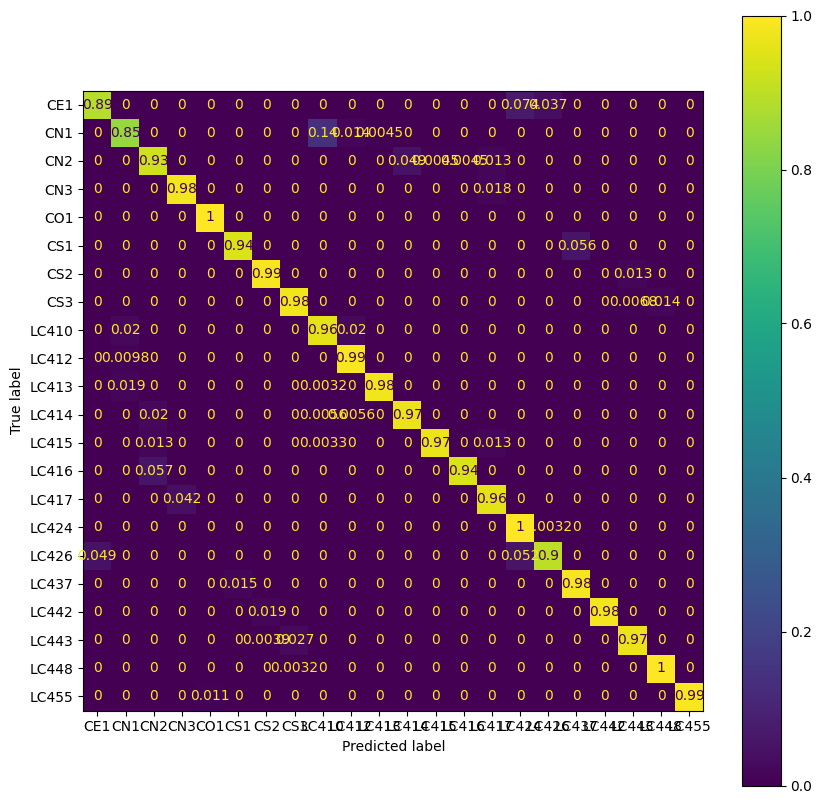

In [12]:
## Presentation of the results
print("Mean accuracy: ", np.mean(accs))
print("Standard deviation of accs: ", np.std(accs))

fig, ax = plt.subplots(figsize=(10,10))
conf_matrix = confusion_matrix(ground_truth, prediction, normalize='true')
cmd = ConfusionMatrixDisplay(conf_matrix, display_labels=list(np.unique(ground_truth)))
cmd.plot(ax=ax)
plt.show()